# PMT Pulse analysis

Jelle, updated May 2019

Standard python setup:

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# This just ensures some comments in dataframes below display nicely
import pandas as pd
pd.options.display.max_colwidth = 100

After this standard setup, we can load straxen:

In [2]:
import straxen
st = straxen.contexts.strax_workshop_dali()

Let's select a background run from SR1 for which we have strax data.

In [3]:
dsets = st.select_runs(available='raw_records', 
                       include_tags='sciencerun1',
                       run_mode='background_stable')
run_id = dsets.name.min()
run_id

Checking data availability: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


'170621_0617'

This run is one hour long, so the full raw waveform data won't fit into memory. Let's instead load only the first 30 seconds:

In [4]:
rr = st.get_array(run_id, 'raw_records', seconds_range=(0, 30))

Not saving raw_records while selecting a time range in the run


The `rr` object is a numpy record array. This works almost like a pandas dataframe, in particular, you can use the same syntax you're used to from dataframes for selections.

Here are the fields you can access:

In [5]:
st.data_info('raw_records')

,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,int32,Integral in ADC x samples
5,pulse_length,int32,Length of pulse to which the record belongs (without zero-padding)
6,record_i,int16,Fragment number in the pulse
7,baseline,float32,Baseline in ADC counts. data = int(baseline) - data_orig
8,reduction_level,uint8,Level of data reduction applied (strax.ReductionLevel enum)
9,data,"('<i2', (110,))",Waveform data in ADC counts above baseline


You now have a matrix (record_i, sample_j) of waveforms in rr['data']:

In [6]:
rr['data'].shape

(2815584, 110)

Let's select only records that belong to short PMT pulses. These are mostly lone PMT hits. Longer pulses are likely part of S1s or S2s.

In [7]:
rr = rr[rr['pulse_length'] < 110]

Here's one record:

Text(0, 0.5, 'Amplitude (ADCc)')

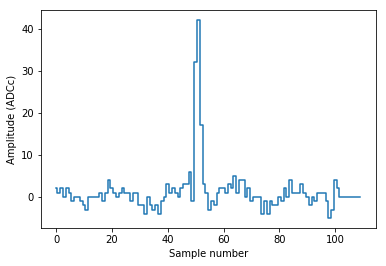

In [8]:
plt.plot(rr['data'][0], linestyle='steps-mid')
plt.xlabel("Sample number")
plt.ylabel("Amplitude (ADCc)")

As you can see, this record contains a single PE pulse. The baseline is already subtracted (and the pulse has been flipped), but no other operations have been done on it. Each record is 110 samples long, but this digitizer pulse was only 102 samples long:

In [9]:
rr['pulse_length'][0]

102

and thus the pulse has been zero-padded, as you can see at the highest sample numbers in the plot above.

Let's focus on channel 100 for now:

In [10]:
r = rr[rr['channel'] == 100]

## Pulse shape

Here is the distribution of amplitudes in each sample. This is very roughly the mean pulse shape:

Text(0, 0.5, 'Amplitude (ADCc)')

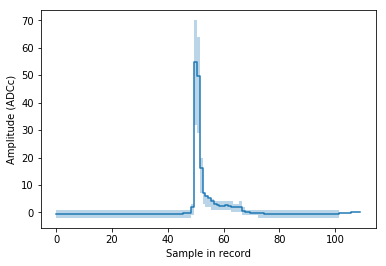

In [11]:
ns = np.arange(len(r['data'][0]))
plt.plot(ns, r['data'].mean(axis=0), linestyle='steps-mid')
plt.fill_between(
    ns,
    np.percentile(r['data'], 25, axis=0),
    np.percentile(r['data'], 75, axis=0), 
    step='mid', alpha=0.3, linewidth=0)
plt.xlabel("Sample in record")
plt.ylabel("Amplitude (ADCc)")

You can clearly see we're dealing with single PEs here, and also see the infamous long PE pulse tail. For a serious pulse shape study you should of course first normalize the pulses.

## Gain calibration

Let's integrate between sample 40 and 70, to get the mean single-PE area. We have to add a small correction for the baseline, see [here](https://github.com/AxFoundation/strax/issues/2) for details. Usually this is done inside strax and you don't have to worry about it.

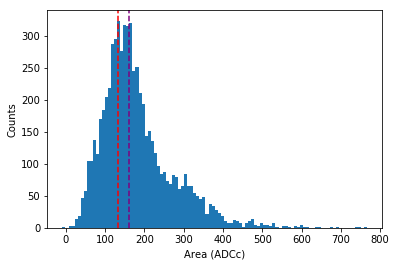

In [12]:
left, right = 40, 70
areas = r['data'][:,left:right].sum(axis=1)

# Small correction for baseline, see strax issue #2
areas += ((r['baseline'] % 1) * (right - left)).round().astype(np.int)

to_pe = straxen.get_to_pe(
    run_id,
    'https://raw.githubusercontent.com/XENONnT/strax_auxiliary_files/d4db78e4e6ffc56a4ac79be86f7d7138f25425fd/to_pe.npy')

plt.hist(areas, bins=100)
plt.xlabel("Area (ADCc)")
plt.ylabel("Counts")
plt.axvline(1/to_pe[100], color='r', linestyle='--')
plt.axvline(np.median(areas), color='purple', linestyle='--')

The purple line is an extremely bad gain estimate (the median area) of pulses, which nonetheless comes close for this PMT. It should be obvious this is a bad method: it takes no account of 2PE hits or the hitfinder efficiency at all.

The red line indicates where the 1 PE area should be according to the XENON1T gain calibration. Looks like the gain is, at least approximately, correct!

Let's do the same for all PMTs:

In [13]:
areas = rr['data'][:,40:70].sum(axis=1)
channels = rr['channel']

gain_ests = np.array([
    np.median(areas[channels == pmt]) 
    for pmt in tqdm(np.arange(248))])

 13%|█▎        | 32/248 [00:00<00:06, 34.78it/s]/home/aalbers/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/aalbers/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 248/248 [00:07<00:00, 34.58it/s]


/home/aalbers/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


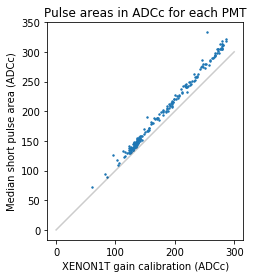

In [14]:
plt.scatter(1/to_pe, gain_ests, s=2)
plt.plot([0, 300], [0, 300], c='k', alpha=0.2)
plt.xlabel("XENON1T gain calibration (ADCc)")
plt.ylabel("Median short pulse area (ADCc)")
plt.title("Pulse areas in ADCc for each PMT")
plt.gca().set_aspect('equal')

As you can see, even this extremely basic method (median area of short pulses in 30sec of background data) gives a somewhat plausible gain estimate for most PMTs.